# Battle of neighborhoods  

## IBM Data Science Certification - Capstone Project

### Author - Luciano Guerra Domínguez


# _Introduction / Problem Definition_

As i defined before I am going to take a course in Georgetown University (Washington DC) and my family and me have to move to this town. 

My wife have a great store in London at Bond Street. This store is really successfull, and we would like to open a new store in Washington trying to copy our London success. So we need to found the closest neighborhood to my University with simillar typollogy to our old neighborhood in London. We believe we could replicate same success with a similar store as in London.

In [1]:
# firts of all I import all necessary packages to my research
import numpy as np
import pandas as pd 
import json
from geopy.geocoders import Nominatim 
import geopy.distance 
import requests 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
!conda install -c conda-forge folium # Remove if it is the first execution while development
import folium # map rendering library
from bs4 import BeautifulSoup

#Using the elbow method to identify the optimal k
!conda install -c districtdatalabs yellowbrick --yes # Remove if it is the first execution while development

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium


The following packages will be DOWNGRADED:

    openssl: 1.0.2s-h7b6447c_0 --> 1.0.2r-h14c3975_0 conda-forge

Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - yellowbrick


The following packages will be UPDATED:

    openssl: 1.0.2r-h14c3975_0 conda-forge --> 1.0.2s-h7b6447c_0

Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Libraries imported.


I obtain the data of Washington from the Open Data DC repository. On this site, the District of Columbia government shares hundreds of datasets. DC realizes that data’s greatest value comes from having it freely shared among agencies, federal and regional governments and with the public to the extent possible when considering safety, privacy and security. The District invites you to browse the data, download it as a file, analyze it with your tools, or build apps using our APIs.

In [2]:
# Washington neighborhood information from open data
washNeighLabelsDF = pd.read_csv("https://opendata.arcgis.com/datasets/c4b0cd43d50949e98e57de9f22b455fc_35.csv")
washNeighLabelsDF.head()

,X,Y,OBJECTID,GIS_ID,NAME,WEB_URL,LABEL_NAME,DATELASTMODIFIED
0,-76.980348,38.855658,1,nhood_050,Fort Stanton,http://NeighborhoodAction.dc.gov,Fort Stanton,2003-04-10T00:00:00.000Z
1,-76.997950,38.841077,2,nhood_031,Congress Heights,http://NeighborhoodAction.dc.gov,Congress Heights,2003-04-10T00:00:00.000Z
2,-76.995636,38.830237,3,nhood_123,Washington Highlands,http://NeighborhoodAction.dc.gov,Washington Highlands,2003-04-10T00:00:00.000Z
3,-77.009271,38.826952,4,nhood_008,Bellevue,http://NeighborhoodAction.dc.gov,Bellevue,2003-04-10T00:00:00.000Z
4,-76.967660,38.853688,5,nhood_073,Knox Hill/Buena Vista,http://NeighborhoodAction.dc.gov,Knox Hill/Buena Vista,2003-04-10T00:00:00.000Z


Changing names to columns to make it easier and filter rows with just Washington information

In [3]:
# Update Neighborhoods labels
washAreaLabelDF = washNeighLabelsDF[['NAME', 'X', 'Y']].copy()
washAreaLabelDF.rename(columns ={'NAME' : 'Neighborhood', 'X' : 'Longitude', 'Y': 'Latitude'}, inplace = True)

washAreaLabelDF['City'] = "Washington"
washAreaDF = washAreaLabelDF
washAreaDF.head()

,Neighborhood,Longitude,Latitude,City
0,Fort Stanton,-76.980348,38.855658,Washington
1,Congress Heights,-76.997950,38.841077,Washington
2,Washington Highlands,-76.995636,38.830237,Washington
3,Bellevue,-77.009271,38.826952,Washington
4,Knox Hill/Buena Vista,-76.967660,38.853688,Washington


Download information of London to check the neirborhood where our store is placed. We use de London Datastore that is a free and open data-sharing portal  where anyone can access data relating to the capital.  Whether you’re a citizen, business owner, researcher or developer, the site provides over 700 datasets to help you understand the city and develop solutions to London’s problems. Please do have a look around, and let us know what you think.

In [4]:
londNeighLablesDF = pd.read_csv("https://data.london.gov.uk/download/london-borough-profiles/c1693b82-68b1-44ee-beb2-3decf17dc1f8/london-borough-profiles.csv", encoding = "ISO-8859-1")
londNeighLablesDF.head()

,Code,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,Inland_Area_(Hectares),Population_density_(per_hectare)_2017,"Average_Age,_2017","Proportion_of_population_aged_0-15,_2015","Proportion_of_population_of_working-age,_2015",...,Happiness_score_2011-14_(out_of_10),Anxiety_score_2011-14_(out_of_10),Childhood_Obesity_Prevalance_(%)_2015/16,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Political_control_in_council,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections
0,E09000001,City of London,Inner London,8800,5326,290,30.3,43.2,11.4,73.1,...,6.0,5.6,NaN,2.6,129,.,.,.,.,.
1,E09000002,Barking and Dagenham,Outer London,209000,78188,"3,611",57.9,32.9,27.2,63.1,...,7.1,3.1,28.5,7.3,228,Lab,0,100,0,36.5
2,E09000003,Barnet,Outer London,389600,151423,"8,675",44.9,37.3,21.1,64.9,...,7.4,2.8,20.7,6.0,134,Cons,50.8,.,1.6,40.5
3,E09000004,Bexley,Outer London,244300,97736,"6,058",40.3,39.0,20.6,62.9,...,7.2,3.3,22.7,6.9,164,Cons,71.4,23.8,0,39.6
4,E09000005,Brent,Outer London,332100,121048,"4,323",76.8,35.6,20.9,67.8,...,7.2,2.9,24.3,7.9,169,Lab,9.5,88.9,1.6,36.3


Modifying and filtering information to convert it in a simillar Dataframe as washAreaDF

In [5]:
# Update Neighborhoods labels
londAreaLabelDF = londNeighLablesDF[['Code', 'Area_name']].copy()

londAreaLabelDF.reset_index(drop=True,inplace=True)
londAreaLabelDF = londAreaLabelDF[londAreaLabelDF['Code'].str.contains("E09")] # Just Areas in London
londAreaLabelDF.rename(columns ={'Area_name' : 'Neighborhood'}, inplace = True)
londAreaLabelDF.head()

,Code,Neighborhood
0,E09000001,City of London
1,E09000002,Barking and Dagenham
2,E09000003,Barnet
3,E09000004,Bexley
4,E09000005,Brent


Using Nominatim API we update every neighborhood with its longitude and latitude.

In [6]:
# Include latitude and longitude for London dataframe
londAreaDF = pd.DataFrame()

londAreaLabelDF.reset_index(drop=True,inplace=True)
for ctr in range(londAreaLabelDF.shape[0]):
    locations = londAreaLabelDF.loc[ctr,'Neighborhood']

    #find the location data, ignore the neighborhoods that are unable to be located by Nominatim
    geolocator = Nominatim(user_agent="mycapstoneproject")
    location = geolocator.geocode("{},London, United Kingdom, ".format(locations))
       
    londAreaDF = londAreaDF.append({'City': 'London',                                            
                                            'Neighborhood': locations,
                                            'Latitude': location.latitude,
                                            'Longitude': location.longitude
                                           }, ignore_index=True)
londAreaDF.head()

,City,Latitude,Longitude,Neighborhood
0,London,51.515618,-0.091998,City of London
1,London,51.554117,0.150504,Barking and Dagenham
2,London,51.648784,-0.172913,Barnet
3,London,51.441679,0.150488,Bexley
4,London,51.565171,-0.285468,Brent


Now we have simillar structure in the Washington Dataframe and in London Dataframe

We check the position of our actual store in a Map with all other neighborhoods in our dataframe to check the closest neigborhood to it. This should be the example to check a similar neighborhood in Washington.

In [9]:
# map visualization
# create map (my store location)
store_lat = 51.550458
store_lng = 0.003919
map_lond = folium.Map(location=[store_lat, store_lng], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lng, neigh in zip(londAreaDF['Latitude'], londAreaDF['Longitude'], londAreaDF['Neighborhood']):
    label = neigh
    folium.Popup(label, parse_html=True)
    map_lond.add_child(folium.Marker(location=[lat, lng], icon=folium.Icon(icon_color = 'blue', icon='home')))
       
map_lond.add_child(folium.Marker(location=[store_lat,store_lng],icon=folium.Icon(icon_color = 'red', icon='star')))
map_lond

We check minimum distance from our store to a London neighborhood.

In [10]:
store_pos = (store_lat, store_lng)
storeDist = list()
#lat_temp = cleanWashDF.Latitude
#lng_temp = cleanWashDF.Longitude
#temp_pos = (lat_temp, lng_temp)
for neigh in londAreaDF.Neighborhood:    
    lat_temp = float(londAreaDF[londAreaDF.Neighborhood == neigh].Latitude)
    lng_temp = float(londAreaDF[londAreaDF.Neighborhood == neigh].Longitude)
    temp_pos = (lat_temp, lng_temp)    
    storeDist.append(geopy.distance.distance(store_pos, temp_pos).kilometers)
    
londAreaDF['Distance'] = storeDist
londAreaDF[londAreaDF.Distance == londAreaDF['Distance'].min()].Neighborhood

30    Waltham Forest
Name: Neighborhood, dtype: object

This distance say to us **Waltham Forest** is the most relevant neighborhood in the store area in London. Because of this, we should look for a similar neighborhood in Washington.

In [11]:
# Check the London neighborhoods information
londAreaDF.head()

,City,Latitude,Longitude,Neighborhood,Distance
0,London,51.515618,-0.091998,City of London,7.702224
1,London,51.554117,0.150504,Barking and Dagenham,10.175455
2,London,51.648784,-0.172913,Barnet,16.425640
3,London,51.441679,0.150488,Bexley,15.813781
4,London,51.565171,-0.285468,Brent,20.136363


In [12]:
# Check the Washington neighborhoods information
washAreaDF.head()

,Neighborhood,Longitude,Latitude,City
0,Fort Stanton,-76.980348,38.855658,Washington
1,Congress Heights,-76.997950,38.841077,Washington
2,Washington Highlands,-76.995636,38.830237,Washington
3,Bellevue,-77.009271,38.826952,Washington
4,Knox Hill/Buena Vista,-76.967660,38.853688,Washington


In [13]:
# My neighborhood in London is "waltham Forest"
leytonDF = londAreaDF[londAreaDF.Neighborhood == 'Waltham Forest']
leytonDF.head()

,City,Latitude,Longitude,Neighborhood,Distance
30,London,51.556999,-0.005835,Waltham Forest,0.993647


Now I shall append our neighborhood row in the Washington Dataframe. So we shall compare our London neighborhood like a Washington neighborhood.

In [14]:
# We must reset the index
newAreaDF = washAreaDF.append(leytonDF, ignore_index=True)

In [15]:
# Check size of initial dataframe
print(washAreaDF.shape)

(132, 4)


In [16]:
# Check size of final dataframe
print(newAreaDF.shape)

(133, 5)


Check our neighborhood is correctly inserted in the washington Dataframe

In [17]:
newAreaDF[newAreaDF.City == 'London']

,City,Distance,Latitude,Longitude,Neighborhood
132,London,0.993647,51.556999,-0.005835,Waltham Forest


Now we have a Dataframe with all the neighborhoods of Washington and our neighborhood in London. So we can use k-means to create clusters and see how similar is our London place to other Washington areas. This will help us to decide which is the best neighborhood to move.  
I shall compare venues between different neighborhoods to use like predictors in our k-means model.

In [18]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [19]:
# My foursquare credentials
CLIENT_ID = 'RYZSYSHJA4ZWVVWX24N51XNVW0ONA4PPRIZLX0JDAQ3UND2G' # your Foursquare ID
CLIENT_SECRET = 'D5ZO52ZZNRFDACCB1UR2JRXN224UT41PCUJ0A32QLFCPZJQJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RYZSYSHJA4ZWVVWX24N51XNVW0ONA4PPRIZLX0JDAQ3UND2G
CLIENT_SECRET:D5ZO52ZZNRFDACCB1UR2JRXN224UT41PCUJ0A32QLFCPZJQJ


Get venues for all neighborhoods in the Dataframe

In [20]:
newAreavenues = getNearbyVenues(names=newAreaDF['Neighborhood'],
                                   latitudes=newAreaDF['Latitude'],
                                   longitudes=newAreaDF['Longitude'],
                                    radius = radius
                                  )

Fort Stanton
Congress Heights
Washington Highlands
Bellevue
Knox Hill/Buena Vista
Shipley
Douglass
Woodland
Garfield Heights
Near Southeast
Capitol Hill
Dupont Park
Twining
Randle Highlands
Fairlawn
Penn Branch
Barry Farm
Historic Anacostia
Columbia Heights
Logan Circle/Shaw
Cardozo/Shaw
Van Ness
Forest Hills
Georgetown Reservoir
Foxhall Village
Fort Totten
Pleasant Hill
Kenilworth
Eastland Gardens
Deanwood
Fort Dupont
Greenway
Woodland-Normanstone
Mass. Ave. Heights
Naylor Gardens
Pleasant Plains
Hillsdale
Benning Ridge
Penn Quarter
Chinatown
Stronghold
South Central
Langston
Downtown East
North Portal Estates
Colonial Village
Shepherd Park
Takoma
Lamond Riggs
Petworth
Brightwood Park
Manor Park
Brightwood
Hawthorne
Barnaby Woods
Queens Chapel
Michigan Park
North Michigan Park
Woodridge
University Heights
Brookland
Edgewood
Skyland
Bloomingdale
Lincoln Park
16th Street Heights
Fort Lincoln
Gateway
Langdon
Brentwood
Eckington
Truxton Circle
Ivy City
Trinidad
Arboretum
Carver
Mount Vern

Checking the size of the resulting dataframe

In [21]:
print(newAreavenues.shape)
newAreavenues.head()

(6984, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Fort Stanton,38.855658,-76.980348,Anacostia Community Museum,38.856728,-76.976899,Museum
1,Fort Stanton,38.855658,-76.980348,Frederick Douglass National Historic Site (NHS),38.863735,-76.984418,History Museum
2,Fort Stanton,38.855658,-76.980348,Fort Stanton Recreation Center,38.857529,-76.978679,Recreation Center
3,Fort Stanton,38.855658,-76.980348,Fort Stanton Park,38.857541,-76.978266,Park
4,Fort Stanton,38.855658,-76.980348,Massay's Mobile Spa CC,38.857613,-76.987578,Spa


Taking a look at the quantity of venues per neighborhood. Some of them reach the limit.

In [22]:
newAreavenues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
16th Street Heights,35,35,35,35,35,35
Adams Morgan,100,100,100,100,100,100
American University Park,64,64,64,64,64,64
Arboretum,41,41,41,41,41,41
Barnaby Woods,7,7,7,7,7,7
Barry Farm,11,11,11,11,11,11
Bellevue,14,14,14,14,14,14
Benning,29,29,29,29,29,29
Benning Ridge,24,24,24,24,24,24


Finding out how many unique categories can be curated from all the returned venues...

In [23]:
print('There are {} uniques categories.'.format(len(newAreavenues['Venue Category'].unique())))

There are 352 uniques categories.


Once we have enough venues of all neighborhoods, we must use "one hot encoding" to avoid give more weight from a categorical venue to others. 

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

In [24]:
# one hot encoding
newAreavenues_onehot = pd.get_dummies(newAreavenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newAreavenues_onehot['Neighborhood'] = newAreavenues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newAreavenues_onehot.columns[-1]] + list(newAreavenues_onehot.columns[:-1])
newAreavenues_onehot = newAreavenues_onehot[fixed_columns]

#visualizing the size of the dataframe
newAreavenues_onehot.shape

(6984, 352)

Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [25]:
newAreavenues_grouped = newAreavenues_onehot.groupby('Neighborhood').mean().reset_index()
newAreavenues_grouped

,Neighborhood,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Arcade,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,16th Street Heights,0.00,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
1,Adams Morgan,0.00,0.0,0.0100,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.00,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.00
2,American University Park,0.00,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.00
3,Arboretum,0.00,0.0,0.0000,0.024390,0.000000,0.000000,0.000000,0.024390,0.00,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,Barnaby Woods,0.00,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,Barry Farm,0.00,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Bellevue,0.00,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
7,Benning,0.00,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
8,Benning Ridge,0.00,0.0,0.0000,0.000000,0.000000,0.000000,0.041667,0.000000,0.00,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,Bloomingdale,0.00,0.0,0.0000,0.000000,0.000000,0.000000,0.011765,0.000000,0.00,...,0.00,0.00,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765,0.00


In [26]:
#rechecking the new size of the dataframe...
newAreavenues_grouped.shape

(133, 352)

We can see most important venues in our neighborhoods

In [27]:
# Printing each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in newAreavenues_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = newAreavenues_grouped[newAreavenues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----16th Street Heights----
            venue  freq
0        Bus Stop  0.09
1  Cosmetics Shop  0.09
2      Playground  0.06
3            Park  0.06
4          Bakery  0.06


----Adams Morgan----
                  venue  freq
0                   Bar  0.06
1        Ice Cream Shop  0.04
2           Coffee Shop  0.04
3           Pizza Place  0.03
4  Gym / Fitness Center  0.03


----American University Park----
             venue  freq
0      Yoga Studio  0.06
1      Pizza Place  0.06
2      Coffee Shop  0.05
3             Bank  0.05
4  Thai Restaurant  0.03


----Arboretum----
          venue  freq
0  Liquor Store  0.10
1        Garden  0.10
2   Gas Station  0.07
3     Nightclub  0.05
4   Bus Station  0.05


----Barnaby Woods----
                        venue  freq
0  Construction & Landscaping  0.29
1                       Trail  0.29
2                        Park  0.14
3                   BBQ Joint  0.14
4                  Playground  0.14


----Barry Farm----
                 venue  fre

                 venue  freq
0          Gas Station  0.06
1   Chinese Restaurant  0.06
2  Fried Chicken Joint  0.06
3       Hardware Store  0.06
4         Liquor Store  0.06


----Fort McNair----
             venue  freq
0    Boat or Ferry  0.09
1              Gym  0.09
2  Harbor / Marina  0.06
3      Pizza Place  0.06
4          Brewery  0.03


----Fort Stanton----
               venue  freq
0  Convenience Store  0.27
1             Museum  0.09
2      Grocery Store  0.09
3  Recreation Center  0.09
4        Wings Joint  0.09


----Fort Totten----
                  venue  freq
0           Bus Station  0.09
1     Convenience Store  0.09
2  Fast Food Restaurant  0.06
3              Bus Stop  0.06
4                   Gym  0.06


----Foxhall Crescents----
                venue  freq
0    Sushi Restaurant  0.11
1         Pizza Place  0.06
2                Park  0.06
3         Coffee Shop  0.06
4  Belgian Restaurant  0.06


----Foxhall Village----
                  venue  freq
0          Tenn

                venue  freq
0      Sandwich Place  0.04
1                Park  0.04
2         Pizza Place  0.04
3                Café  0.03
4  Italian Restaurant  0.03


----Naylor Gardens----
               venue  freq
0  Convenience Store  0.14
1       Intersection  0.09
2       Liquor Store  0.09
3               Park  0.09
4               Bank  0.05


----Near Northeast----
                           venue  freq
0                    Coffee Shop  0.08
1                            Bar  0.04
2                    Yoga Studio  0.03
3       Mediterranean Restaurant  0.03
4  Vegetarian / Vegan Restaurant  0.03


----Near Southeast----
                venue  freq
0         Pizza Place  0.05
1         Coffee Shop  0.04
2  Italian Restaurant  0.04
3        Burger Joint  0.03
4               Hotel  0.03


----North Capitol Street----
                           venue  freq
0                    Coffee Shop  0.05
1                            Bar  0.04
2  Vegetarian / Vegan Restaurant  0.03
3     

Now I create a function to create a Dataframe with most relevant venues for each neighborhood.

In [28]:
# Puting the information into a datafram
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newAreavenues_grouped['Neighborhood']

for ind in np.arange(newAreavenues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newAreavenues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,16th Street Heights,Cosmetics Shop,Bus Stop,Tennis Court,Park,Playground,Bakery,Fried Chicken Joint,Dog Run,Coffee Shop,Gastropub
1,Adams Morgan,Bar,Ice Cream Shop,Coffee Shop,Gym / Fitness Center,Pizza Place,Spa,Bakery,Mediterranean Restaurant,Yoga Studio,Cocktail Bar
2,American University Park,Pizza Place,Yoga Studio,Coffee Shop,Bank,Frame Store,Bakery,Furniture / Home Store,Park,Deli / Bodega,Indian Restaurant
3,Arboretum,Garden,Liquor Store,Gas Station,Bus Station,Nightclub,Sculpture Garden,Bank,Brewery,Lake,Shipping Store
4,Barnaby Woods,Construction & Landscaping,Trail,BBQ Joint,Playground,Park,Exhibit,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant


#### I shall use k-means to verify in which cluster our neighborhood is within
First of all we shall check best number of cluster with the distortion score elbow method

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


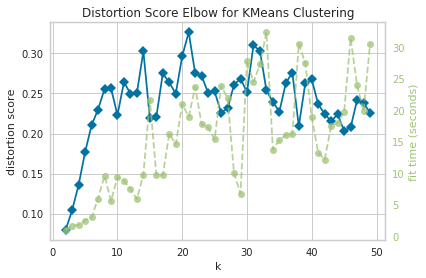

In [31]:
data = newAreavenues_grouped.drop('Neighborhood', 1)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,50), timings=True)

visualizer.fit(data)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

### Clustering Neighborhoods

Running  k-means to cluster the neighborhood into 18 clusters.

In [32]:
# set number of clusters
kclusters = 20

newAreavenues_grouped_clustering = newAreavenues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newAreavenues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([ 9,  3,  7, 17,  6, 10, 14,  4, 17,  0], dtype=int32)

Now I include the cluster ID for each neighborhood

In [34]:
# Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)

newAreaDF_merged = newAreaDF    #########

newAreaDF_merged = newAreaDF_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

newAreaDF_merged.head()

,City,Distance,Latitude,Longitude,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Washington,NaN,38.855658,-76.980348,Fort Stanton,14,Convenience Store,Park,Spa,Wings Joint,Recreation Center,Museum,History Museum,Grocery Store,Medical Center,Event Space
1,Washington,NaN,38.841077,-76.997950,Congress Heights,2,Park,Ice Cream Shop,Bar,Convenience Store,Recreation Center,Deli / Bodega,Road,Fried Chicken Joint,Liquor Store,Basketball Stadium
2,Washington,NaN,38.830237,-76.995636,Washington Highlands,12,Park,Liquor Store,Convenience Store,Asian Restaurant,Seafood Restaurant,Sandwich Place,Grocery Store,Gas Station,Basketball Court,Costume Shop
3,Washington,NaN,38.826952,-77.009271,Bellevue,14,Convenience Store,Gas Station,Grocery Store,Recreation Center,Pizza Place,Pharmacy,Chinese Restaurant,Bank,Hotel,Intersection
4,Washington,NaN,38.853688,-76.967660,Knox Hill/Buena Vista,14,Convenience Store,Wings Joint,Liquor Store,Mobile Phone Shop,Gym / Fitness Center,Fast Food Restaurant,Shopping Mall,Shoe Store,Check Cashing Service,Sandwich Place


Checking the cluster our London type neighborhood is in.

In [35]:
newAreaDF_merged[newAreaDF_merged.City == 'London']

,City,Distance,Latitude,Longitude,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
132,London,0.993647,51.556999,-0.005835,Waltham Forest,7,Pub,Restaurant,Grocery Store,Coffee Shop,Park,Gym,Gym / Fitness Center,Italian Restaurant,Fried Chicken Joint,Sandwich Place


Copy all information to our cluster in the same Dataframe

In [37]:
clusterNeigh = newAreaDF_merged[newAreaDF_merged.Cluster == 7]
clusterNeigh.shape

(27, 16)

We verify that all neighborhoods are not London, except ours.

In [38]:
clusterNeigh = clusterNeigh[clusterNeigh.City != 'London']
clusterNeigh.shape

(26, 16)

In [39]:
neighCluster = newAreaDF_merged[newAreaDF_merged.City == 'London'].Cluster
neighCluster

132    7
Name: Cluster, dtype: int32

The complete cluster of Washington

In [40]:
clusterNeigh

,City,Distance,Latitude,Longitude,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Washington,NaN,38.943391,-77.066106,Van Ness,7,Sandwich Place,Gym,Pool,Park,Italian Restaurant,Rental Car Location,Coffee Shop,Indian Restaurant,Bank,Gym / Fitness Center
22,Washington,NaN,38.946893,-77.058462,Forest Hills,7,Rental Car Location,Sandwich Place,Performing Arts Venue,Park,Indian Restaurant,Trail,Gym / Fitness Center,Italian Restaurant,Farm,Garden
23,Washington,NaN,38.909637,-77.090677,Georgetown Reservoir,7,Park,Gym / Fitness Center,Pool,Grocery Store,Chinese Restaurant,Sandwich Place,Tennis Court,Coffee Shop,Mediterranean Restaurant,Lake
24,Washington,NaN,38.913247,-77.084407,Foxhall Village,7,Tennis Court,Sandwich Place,Deli / Bodega,Gym / Fitness Center,Café,Bagel Shop,Dog Run,Park,Pool,Lake
32,Washington,NaN,38.922850,-77.060753,Woodland-Normanstone,7,Gym,Coffee Shop,Pharmacy,Sushi Restaurant,Playground,Pizza Place,American Restaurant,Park,Hotel Bar,Sandwich Place
33,Washington,NaN,38.925399,-77.070075,Mass. Ave. Heights,7,Playground,Pizza Place,Gym,Indian Restaurant,Bus Stop,Mexican Restaurant,Pharmacy,Italian Restaurant,Sandwich Place,Bar
44,Washington,NaN,38.991765,-77.040877,North Portal Estates,7,Gym,Chinese Restaurant,Grocery Store,Sandwich Place,Coffee Shop,Spa,Optical Shop,Park,Diner,Outdoor Sculpture
46,Washington,NaN,38.982980,-77.032126,Shepherd Park,7,Park,Pizza Place,Liquor Store,Asian Restaurant,Convenience Store,Gym,Brewery,South American Restaurant,Bank,Seafood Restaurant
52,Washington,NaN,38.966379,-77.026874,Brightwood,7,Pizza Place,Park,Sandwich Place,Mexican Restaurant,Café,Seafood Restaurant,Martial Arts Dojo,Caribbean Restaurant,Big Box Store,Trail
59,Washington,NaN,38.938249,-76.995762,University Heights,7,Sandwich Place,Bookstore,Art Gallery,Bus Stop,Spa,American Restaurant,Coffee Shop,Convenience Store,Bar,College Bookstore


Including in a map the location of the Georgetown University with Nominatim.


In [42]:
#from geopy.geocoders import Nominatim
address = 'Georgetown University'

geolocator = Nominatim(user_agent="'Georgetown University'")
location = geolocator.geocode(address)
latitude_GU = location.latitude
longitude_GU = location.longitude

map_wash = folium.Map(location=[latitude_GU, longitude_GU], zoom_start=12)

print('The geograpical coordinate of Georgetown University is {}, {}.'.format(latitude_GU, longitude_GU))
map_wash.add_child(folium.Marker(location=[latitude_GU,longitude_GU],icon=folium.Icon(icon_color = 'red', icon='star')))

The geograpical coordinate of Georgetown University is 38.90893925, -77.0745796206083.


Representing all neighborhoods in Washington colored by cluster and Georgetown University.

In [44]:
# Matplotlib and associated plotting modules
#import matplotlib.cm as cm
#import matplotlib.colors as colors
#%matplotlib inline

# create map
map_clusters = folium.Map(location=[latitude_GU, longitude_GU], zoom_start=12)
map_clusters.add_child(folium.Marker(location=[latitude_GU,longitude_GU],icon=folium.Icon(icon_color = 'red', icon='star')))

# set number of clusters
#kclusters = 3

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
wash_merged = newAreaDF_merged[newAreaDF_merged.City != 'London']
for lat, lon, poi, cluster in zip(wash_merged['Latitude'], wash_merged['Longitude'], wash_merged['Neighborhood'], wash_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters),
       
map_clusters

Show just Georgetown University with all neighborhoods in the same cluster as our London neighborhood.

In [45]:
# map visualization
# create new map (Washington)
clusterNeigh = wash_merged[wash_merged.Cluster == int(neighCluster)]
# add markers to the map
markers_colors = []
for lat, lng, neigh in zip(clusterNeigh['Latitude'], clusterNeigh['Longitude'], clusterNeigh['Neighborhood']):
    label = neigh
    folium.Popup(label, parse_html=True)
    map_wash.add_child(folium.Marker(location=[lat, lng], icon=folium.Icon(icon_color = 'blue', icon='home')))
       
#map_wash.add_child(folium.Marker(location=[latitude_GU,longitude_GU],icon=folium.Icon(icon_color = 'red', icon='star')))
map_wash

Finally I obtain the closest neighborhood to the Georgetown University

In [46]:
GU_pos = (latitude_GU, longitude_GU)
Distance = list()
#lat_temp = cleanWashDF.Latitude
#lng_temp = cleanWashDF.Longitude
#temp_pos = (lat_temp, lng_temp)
for neigh in clusterNeigh.Neighborhood:    
    lat_temp = float(clusterNeigh[clusterNeigh.Neighborhood == neigh].Latitude)
    lng_temp = float(clusterNeigh[clusterNeigh.Neighborhood == neigh].Longitude)
    temp_pos = (lat_temp, lng_temp)    
    Distance.append(geopy.distance.distance(GU_pos, temp_pos).kilometers)
    
clusterNeigh['Distance'] = Distance

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
clusterNeigh[clusterNeigh.Distance == clusterNeigh['Distance'].min()].Neighborhood


85    Burleith/Hillandale
Name: Neighborhood, dtype: object

In [48]:
clusterNeigh

,City,Distance,Latitude,Longitude,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Washington,3.894524,38.943391,-77.066106,Van Ness,7,Sandwich Place,Gym,Pool,Park,Italian Restaurant,Rental Car Location,Coffee Shop,Indian Restaurant,Bank,Gym / Fitness Center
22,Washington,4.439137,38.946893,-77.058462,Forest Hills,7,Rental Car Location,Sandwich Place,Performing Arts Venue,Park,Indian Restaurant,Trail,Gym / Fitness Center,Italian Restaurant,Farm,Garden
23,Washington,1.398421,38.909637,-77.090677,Georgetown Reservoir,7,Park,Gym / Fitness Center,Pool,Grocery Store,Chinese Restaurant,Sandwich Place,Tennis Court,Coffee Shop,Mediterranean Restaurant,Lake
24,Washington,0.977379,38.913247,-77.084407,Foxhall Village,7,Tennis Court,Sandwich Place,Deli / Bodega,Gym / Fitness Center,Café,Bagel Shop,Dog Run,Park,Pool,Lake
32,Washington,1.955179,38.922850,-77.060753,Woodland-Normanstone,7,Gym,Coffee Shop,Pharmacy,Sushi Restaurant,Playground,Pizza Place,American Restaurant,Park,Hotel Bar,Sandwich Place
33,Washington,1.868539,38.925399,-77.070075,Mass. Ave. Heights,7,Playground,Pizza Place,Gym,Indian Restaurant,Bus Stop,Mexican Restaurant,Pharmacy,Italian Restaurant,Sandwich Place,Bar
44,Washington,9.647861,38.991765,-77.040877,North Portal Estates,7,Gym,Chinese Restaurant,Grocery Store,Sandwich Place,Coffee Shop,Spa,Optical Shop,Park,Diner,Outdoor Sculpture
46,Washington,9.005961,38.982980,-77.032126,Shepherd Park,7,Park,Pizza Place,Liquor Store,Asian Restaurant,Convenience Store,Gym,Brewery,South American Restaurant,Bank,Seafood Restaurant
52,Washington,7.600643,38.966379,-77.026874,Brightwood,7,Pizza Place,Park,Sandwich Place,Mexican Restaurant,Café,Seafood Restaurant,Martial Arts Dojo,Caribbean Restaurant,Big Box Store,Trail
59,Washington,7.570016,38.938249,-76.995762,University Heights,7,Sandwich Place,Bookstore,Art Gallery,Bus Stop,Spa,American Restaurant,Coffee Shop,Convenience Store,Bar,College Bookstore
